# VQE for upper spins

Author: Javier Norambuena Leiva — Posted: . Last updated: .

Here we discust and test how to implement the variational quantum eigensolver for spin systems (chain , rings and more complex structures) when this one is different of one half. In the following section we see the different formulas to calculate the expected value and how to construct the ansatz in a simple way.

In [1]:
import math
import itertools
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import scipy.linalg as la
import scipy as sc
import random

random.seed(42)

## The main idea

The variational quantum eigensolver (VQE) is a central computational method in the NISQ era for its robustness against noise. The majority of tutorials that involve VQE with a Heisenberg model only consider the base case, which is spin one-half.

This is a limitation when one tries to study spin systems that have upper spins, for example, the single molecular magnet 3Ni is studied with a Heisenberg model, but each site has a spin of one. Here, we propose an approach to studying this kind of system when the spin of the model is different from one-half.

To perform this, we need to focus on two things: the expected value formula and the basis representation. Let's begin with the latter. Let's consider a spin-1. We know that this spin is represented as a three-level system. Therefore, an arbitrary state is written as:

$$\ket{\psi} = \alpha\ket{0} + \beta\ket{1} + \gamma\ket{2}$$

The key idea is to try to rewrite these three states into an n-qubit set. Thus, we need to find the minimum number of qubits that allow us to contain our set of states in the basis of the n-qubit. For our example case, we need two qubits. So, we can encode it like this:

$$\ket{0} \longrightarrow \ket{00}$$
$$\ket{1} \longrightarrow \ket{01}$$
$$\ket{2} \longrightarrow \ket{10}$$

This leaves us with a state in the qubit that doesn't have any meaning. Thus, we need to tell the method to try not to choose the left state. A naive idea could be to add a penalty term if some samples go to the left state.

Let's leave this for a moment and move to the expected value formula. Let's remember the formula for the expected value of the Z Pauli operator of spin one-half:

$$ \bra{\psi}Z\ket{\psi} = \bra{\psi}( \ket{0}\bra{0} - \ket{1}\bra{1} )\ket{\psi} = |\bra{0}\ket{\psi}|^2 - |\bra{1}\ket{\psi}|^2$$

As we can see, the expected value is the difference of the projection of $\ket{\psi}$ into the basis states. This approach is the same for upper spins. If we change to the Z Pauli operator of spin one, the formula changes a little bit:

$$ \bra{\psi}Z\ket{\psi} = \bra{\psi}( \ket{0}\bra{0} - \ket{2}\bra{2} )\ket{\psi} = |\bra{0}\ket{\psi}|^2 - |\bra{2}\ket{\psi}|^2$$

And as we defined above, this probability can be written in the 2-qubit basis, giving us the following result:
$$ |\bra{00}\ket{\psi}|^2 - |\bra{10}\ket{\psi}|^2$$

The before formula was for one qutrit, but what happen with interaction between qutrit. Two qutrit create a space of 9 basis states, so we need 4-qubits to represent it, but how we codify this,  

This idea for spin one can be used for every spin with the condition of knowing the states that compose the Z Pauli operator (in other words, having the matrix).

Here, you can find the explicit definition of the Pauli matrices for spin 5/2 (https://easyspin.org/easyspin/documentation/spinoperators.html).

## System definition

For simplicity, let consider a ring of three qudits of spin 1 and 1/5 that is represented using a Heisenberg model with only Z interaction without a external field, to represent the hamiltonian, we will use a list of Pauli string representation.

In [2]:
nr_qudits = 3
list_spines = [0.5, 1, 1.5]
J = 1

Hamiltonian = [(('ZZI', -J)), (('IZZ', -J)), (('ZIZ', -J))]
Hamiltonian_index = [ [0,1], [1,2], [0,2] ]

## Creation of Ansatz Circuit

As we need to treat with a bigger set of states, it's necessary explain how to construct the ansatz that will help to find the ground state energy. To ...

In [3]:
def single_rotation(phi_params, qubits, spin):
        correction = math.ceil( (int( 2*spin+1 ))/2  )
        for i in range( 0, qubits):
            for j in range(correction):
                qml.RZ(phi_params[i][0], wires=[correction*i+j])
                qml.RY(phi_params[i][1], wires=[correction*i+j])
                qml.RX(phi_params[i][2], wires=[correction*i+j])
        return

def non_local_gates(phi_params, qubits, spin):
        correction = math.ceil( (int( 2*spin+1 ))/2  )
        for i in range(0, qubits-1):
            for j in range(correction):
                qml.CRX(phi_params[i], [correction*i+j, correction*(i+1)+j])
        return

In [4]:
def quantum_circuit(qubits, spin, repetition, rotation_params, coupling_params, wire, sample=None):
    correction = math.ceil( (int( 2*spin+1 ))/2  )
    qml.BasisState(sample, wires=range(correction*qubits))
    for i in range(0, repetition):
        single_rotation(rotation_params[i], qubits, spin)
        non_local_gates(coupling_params[i], qubits, spin)
    index_wire = []
    for w in wire:
        for i in range(correction):
            index_wire.append( correction*w + i)
    return qml.counts(wires=index_wire)

## Cost function

The cost function is the same of VQE but rewrited in the following way.
$$E_0 = \bra{\phi} H \ket{\phi} = \bra{\phi} (\sum_i -Jh_i) \ket{\phi} = \sum_i -J \bra{\phi}h_i\ket{\phi}$$

Each $$\bra{\phi}h_i\ket{\phi}$$


In [5]:
conts_spin = {"0.5": {'00':1, '11':1, '01': -1, '10':-1},
            "1": {'0000':1, '1010':1, '0010': -1, '1000':-1},
            "1.5": {'0000':9/4, '0001':3/4, '0010':-3/4, '0011':-9/4, 
                    '0100':3/4, '0101':1/4, '0110':-1/4, '0111':-3/4,
                    '1000':-3/4, '1001':-1/4, '1010':1/4, '1011':-3/4,
                    '1100':-9/4, '1101':-3/4, '1110':3/4, '1111':9/4},
    }


repetition = 3
local_number = 3*nr_qudits*repetition
non_local_number = int( nr_qudits*repetition )

In [6]:
dict_evolution =  {"0.5":[], "1":[], "1.5":[],}

def cost_function_VQE(theta: list, hf, spin, node, shots) -> float:
        ansatz_params_1 = theta[0 : non_local_number]
        ansatz_params_2 = theta[non_local_number: ]

        coupling = np.split(ansatz_params_1, repetition)
        split = np.split(ansatz_params_2, repetition)
        rotation = []
        for s in split:
            rotation.append(np.split(s, 3))

        result= 0.0
        for i, term in enumerate(Hamiltonian_index):
            result_term = node( qubits= nr_qudits, spin=spin, repetition=repetition, 
                               rotation_params = rotation, coupling_params = coupling, wire = term, sample=hf )
            for _, dict_term in enumerate( conts_spin[ str(spin) ] ):
                if dict_term in result_term:
                    exchange = Hamiltonian[i][1]
                    prob = result_term[dict_term]/shots
                    const_state = conts_spin[ str(spin) ][dict_term]
                    result += exchange*prob*const_state
        dict_evolution[str(spin)].append(result)
        return result

## Execution of VQE

### Spin $\frac{1}{2}$

In [7]:
spin = 0.5
shots = 3000
correction = math.ceil( (int( 2*spin+1 ))/2  )
hf = qml.qchem.hf_state(2*correction, nr_qudits*correction)
theta = np.array( [np.random.randint(-300, 300) / 100  for _ in range(local_number + non_local_number)])

device = qml.device( "default.qubit" , wires=correction*nr_qudits, shots=shots)
node = qml.QNode(quantum_circuit, device, interface="autograd")

general_cost_function = lambda theta: cost_function_VQE(theta, hf, spin, node, shots)
xs = sc.optimize.minimize(general_cost_function, theta, method='COBYLA',
        options={'tol': 1e-6, 'maxiter': 1000})['x']

### Spin $1$

In [8]:
spin = 1
shots =  3000
correction = math.ceil( (int( 2*spin+1 ))/2  )
hf = qml.qchem.hf_state(2*correction, nr_qudits*correction)
theta = np.array( [np.random.randint(-300, 300) / 100  for _ in range(local_number + non_local_number)])

device = qml.device( "default.qubit" , wires=correction*nr_qudits, shots=shots)
node = qml.QNode(quantum_circuit, device, interface="autograd")

general_cost_function = lambda theta: cost_function_VQE(theta, hf, spin, node, shots)
xs = sc.optimize.minimize(general_cost_function, theta, method='COBYLA',
        options={'tol': 1e-6, 'maxiter': 1000})['x']

### Spin $\frac{3}{2}$

In [9]:
spin = 1.5
shots = 3000
correction = math.ceil( (int( 2*spin+1 ))/2  )
hf = qml.qchem.hf_state(2*correction, nr_qudits*correction)
theta = np.array( [np.random.randint(-300, 300) / 100  for _ in range(local_number + non_local_number)])

device = qml.device( "default.qubit" , wires=correction*nr_qudits, shots=shots)
node = qml.QNode(quantum_circuit, device, interface="autograd")

general_cost_function = lambda theta: cost_function_VQE(theta, hf, spin, node, shots)
xs = sc.optimize.minimize(general_cost_function, theta, method='COBYLA',
        options={'tol': 1e-6, 'maxiter': 1000})['x']

## Exact result

Now we need to compare with the actual solution of the previous situation, here we will calculate the eigenvalues using the matrix description of the Z pauli matrix and the eigensolver function of numpy.

The following shell show the matrix representation of the Z operation of different spines, as we can see, for each spin the size of the matrix is incresed making the system space bigger and bigger.

In [10]:
si0_5 = np.array([[1,0], [0,1]]) 
sz0_5 = np.array([[1,0], [0,-1]]) 

si1 = np.array([[1,0,0], [0,1,0], [0,0,1]]) 
sz1 = np.array([[1,0,0], [0,0,0], [0,0,-1]]) 

si1_5 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]) 
sz1_5 = np.array([[1.5,0,0,0], [0,0.5,0,0], [0,0,-0.5,0], [0,0,0,-1.5]]) 

Spin0_5_Hamiltonian = -J*( np.kron(sz0_5, np.kron(sz0_5, si0_5)) + np.kron(si0_5, np.kron(sz0_5, sz0_5)) + np.kron(sz0_5, np.kron(si0_5, sz0_5)) )
Spin1_Hamiltonian = -J*( np.kron(sz1, np.kron(sz1, si1)) + np.kron(si1, np.kron(sz1, sz1)) + np.kron(sz1, np.kron(si1, sz1)) )
Spin1_5_Hamiltonian = -J*( np.kron(sz1_5, np.kron(sz1_5, si1_5)) + np.kron(si1_5, np.kron(sz1_5, sz1_5)) + np.kron(sz1_5, np.kron(si1_5, sz1_5)) )

In [11]:
E_0_spin_0_5 = np.linalg.eigvalsh(Spin0_5_Hamiltonian)[0]
E_0_spin_1 = np.linalg.eigvalsh(Spin1_Hamiltonian)[0]
E_0_spin_1_5 = np.linalg.eigvalsh(Spin1_5_Hamiltonian)[0]

print(f"Minimun energy of spin 0.5: {E_0_spin_0_5}")
print(f"Minimun energy of spin 1: {E_0_spin_1}")
print(f"Minimun energy of spin 1.5: {E_0_spin_1_5}")

Minimun energy of spin 0.5: -3.0
Minimun energy of spin 1: -3.0
Minimun energy of spin 1.5: -6.75


## Numerical results

Now, let combine all the previous result and see how the process go.

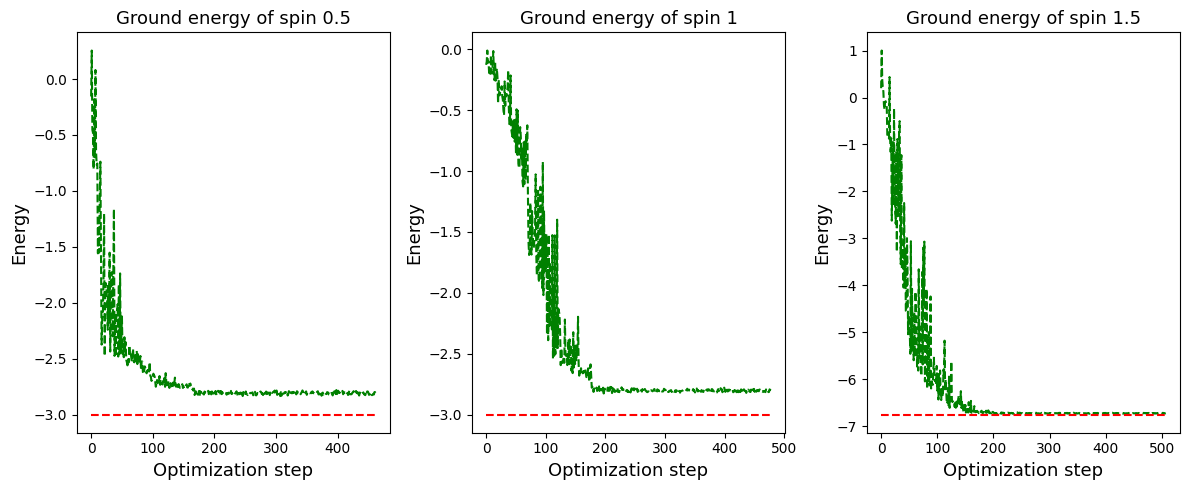

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(12,5),)
for i in range(3):
    ax[i].set_xlabel("Optimization step", fontsize=13)
    ax[i].set_ylabel("Energy", fontsize=13)
    ax[i].set_title(f"Ground energy of spin {list_spines[i]}", fontsize=13)
ax[0].plot(range(len(dict_evolution["0.5"])), dict_evolution["0.5"], "g", ls="dashed")
ax[0].plot(range(len(dict_evolution["0.5"])), [E_0_spin_0_5 for i in range(len(dict_evolution["0.5"]))], "r", ls="dashed")

ax[1].plot(range(len(dict_evolution["1"])), dict_evolution["1"], "g", ls="dashed")
ax[1].plot(range(len(dict_evolution["1"])), [E_0_spin_1 for i in range(len(dict_evolution["1"]))], "r", ls="dashed")

ax[2].plot(range(len(dict_evolution["1.5"])), dict_evolution["1.5"], "g", ls="dashed")
ax[2].plot(range(len(dict_evolution["1.5"])), [E_0_spin_1_5 for i in range(len(dict_evolution["1.5"]))], "r", ls="dashed")
fig.tight_layout()
plt.show()

As we can see, for each spin, the extension of the variational quantum eigensolver converge to the minimun energy of the hamiltonian of different spin

## Conclusion

Systems of higher spines it's not something that you will find so often, but there are some cases ...